In [22]:
import torch
import torch.nn as nn
import torch.optim
import torchvision
import torchvision.transforms.v2 as v2
import torchvision.datasets
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

import random

from tqdm import tqdm

torch.Size([1, 32, 32])


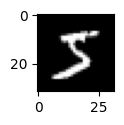

In [23]:
transform = v2.Compose([
    v2.Pad(2),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5], std=[0.5]),
])

train_dataset = torchvision.datasets.MNIST(root='./dataset', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./dataset', train=False, transform=transform, download=True)

x, y = train_dataset[0]
print(x.shape)
x = x.squeeze(0)
plt.figure(figsize=(1,1))
plt.imshow(x, cmap='gray')
plt.show()

In [31]:
print(x.shape)
print(x.unique())

torch.Size([32, 32])
tensor([-1.0000, -0.9922, -0.9843, -0.9765, -0.9294, -0.9137, -0.8902, -0.8745,
        -0.8588, -0.8196, -0.8118, -0.8039, -0.7961, -0.7882, -0.7647, -0.7255,
        -0.7176, -0.6941, -0.6627, -0.6471, -0.6392, -0.6157, -0.5686, -0.5608,
        -0.4980, -0.4824, -0.4510, -0.3882, -0.3725, -0.3647, -0.3569, -0.2941,
        -0.2706, -0.2627, -0.1608, -0.1529, -0.1059, -0.0667, -0.0118, -0.0039,
         0.0196,  0.0353,  0.0431,  0.0588,  0.0667,  0.0902,  0.1608,  0.1765,
         0.2078,  0.2235,  0.2549,  0.3020,  0.3333,  0.3412,  0.3490,  0.3725,
         0.4275,  0.4353,  0.4588,  0.4667,  0.4902,  0.5294,  0.5529,  0.5765,
         0.6078,  0.6235,  0.6627,  0.6706,  0.7176,  0.7333,  0.7647,  0.7725,
         0.7961,  0.8667,  0.8824,  0.8902,  0.8980,  0.9137,  0.9373,  0.9529,
         0.9608,  0.9686,  0.9765,  0.9843,  1.0000])


In [36]:
class Ebm(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.activation = nn.SiLU()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(in_features=256, out_features=64)
        self.dense2 = nn.Linear(in_features=64, out_features=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        out = self.conv3(out)
        out = self.activation(out)
        out = self.conv4(out)
        out = self.activation(out)
        out = self.activation(out)
        out = self.flatten(out)
        out = self.dense1(out)
        out = self.activation(out)
        out = self.dense2(out)

        return out

model = Ebm()
sample = train_dataset[0][0].unsqueeze(0)
print(sample.shape)
out = model(sample)
print(out.shape)
print(out)


torch.Size([1, 1, 32, 32])
torch.Size([1, 1])
tensor([[0.1155]], grad_fn=<AddmmBackward0>)


In [38]:
def generate_samples(model, inp_imgs, steps, step_size, noise, return_img_per_step=False):
    imgs_per_step = []

    for _ in range(steps):
        # add noise
        inp_imgs += torch.randn(inp_imgs.shape, device=inp_imgs.device) * noise # noise : stddev
        inp_imgs = torch.clip(inp_imgs, min=-1.0, max=1.0)

        # get energy score
        inp_imgs.requires_grad_(True)
        out_score = model(inp_imgs)

        # calculate gradiant
        grads = torch.autograd.grad(
            outputs=out_score,
            inputs=inp_imgs,
            grad_outputs=torch.ones_like(out_score))[0]

        grads = torch.clip(grads, min=-0.03, max=0.03)

        # add gradiant to image
        inp_imgs += step_size * grads
        inp_imgs = torch.clip(inp_imgs, min=-1.0, max=1.0)
        if return_img_per_step:
            imgs_per_step.append(inp_imgs.detach())

    inp_imgs = inp_imgs.detach()
    if return_img_per_step:
        return inp_imgs, imgs_per_step
    else:
        return inp_imgs


In [39]:
# Generating samples from model to train
class Buffer:
    def __init__(self, model, batch_size, device) -> None:
        super().__init__()
        self.model = model
        self.batch_size = batch_size
        self.device = device
        self.examples = [
            torch.rand([1, 1,32,32], device=device) * 2 - 1 for _ in range(batch_size)
        ]

    def sample_new_exmps(self, steps, step_size, noise):
        n_new = np.random.binomial(self.batch_size, 0.05)
        rand_imgs = (
            torch.rand([n_new, 1, 32,32], requires_grad=True, device=device) * 2 - 1
        )
        choice_d = random.choices(self.examples, k=(self.batch_size - n_new))
        old_imgs = torch.cat(
            choice_d, dim=0
        )
        inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0)
        inp_imgs = inp_imgs.to(device)
        inp_imgs = generate_samples(
            self.model, inp_imgs, steps, step_size, noise
        )
        self.examples = list(torch.split(inp_imgs, 1, dim=0))  + self.examples
        self.examples = self.examples[:8192]
        return inp_imgs

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
buffer = Buffer(model, 16, device)
res = buffer.sample_new_exmps(steps=60, step_size=10, noise=0.005)
print(res.shape)


torch.Size([16, 1, 32, 32])


train[0]: 100%|██████████| 469/469 [01:07<00:00,  6.98it/s, loss:0.03115]


epoch[0] : -0.00224


test[0]: 100%|██████████| 469/469 [00:21<00:00, 22.31it/s]


epoch[0] : test loss - 0.03115


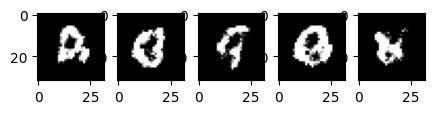

train[1]: 100%|██████████| 469/469 [01:07<00:00,  6.92it/s, loss:0.02920]


epoch[1] : -0.00067


test[1]: 100%|██████████| 469/469 [00:21<00:00, 22.11it/s]


epoch[1] : test loss - 0.02920


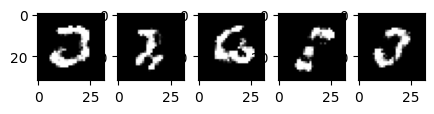

train[2]: 100%|██████████| 469/469 [01:07<00:00,  6.95it/s, loss:0.01812]


epoch[2] : -0.00082


test[2]: 100%|██████████| 469/469 [00:21<00:00, 22.00it/s]


epoch[2] : test loss - 0.01812


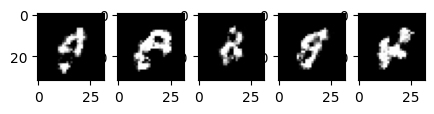

train[3]: 100%|██████████| 469/469 [01:07<00:00,  6.92it/s, loss:0.01401]


epoch[3] : -0.00020


test[3]: 100%|██████████| 469/469 [00:21<00:00, 21.95it/s]


epoch[3] : test loss - 0.01401


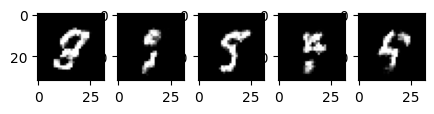

train[4]: 100%|██████████| 469/469 [01:08<00:00,  6.80it/s, loss:0.00788]


epoch[4] : -0.00018


test[4]: 100%|██████████| 469/469 [00:21<00:00, 22.06it/s]


epoch[4] : test loss - 0.00788


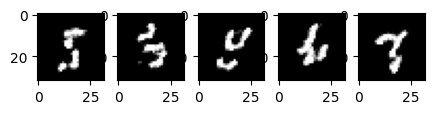

train[5]: 100%|██████████| 469/469 [01:06<00:00,  7.01it/s, loss:0.00990]


epoch[5] : -0.00008


test[5]: 100%|██████████| 469/469 [00:21<00:00, 22.11it/s]


epoch[5] : test loss - 0.00990


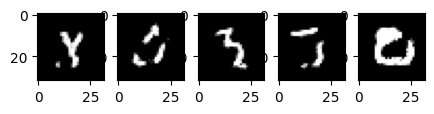

train[6]: 100%|██████████| 469/469 [01:06<00:00,  7.04it/s, loss:0.01088]


epoch[6] : -0.00033


test[6]: 100%|██████████| 469/469 [00:21<00:00, 22.20it/s]


epoch[6] : test loss - 0.01088


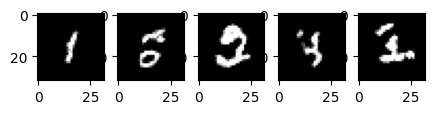

train[7]: 100%|██████████| 469/469 [01:06<00:00,  7.01it/s, loss:0.00619]


epoch[7] : 0.00004


test[7]: 100%|██████████| 469/469 [00:21<00:00, 22.20it/s]


epoch[7] : test loss - 0.00619


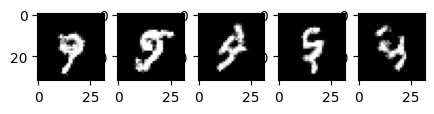

train[8]: 100%|██████████| 469/469 [01:07<00:00,  6.97it/s, loss:0.00469]


epoch[8] : -0.00018


test[8]: 100%|██████████| 469/469 [00:21<00:00, 22.25it/s]


epoch[8] : test loss - 0.00469


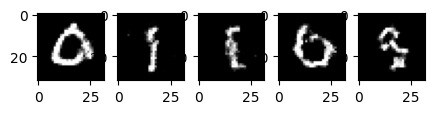

train[9]: 100%|██████████| 469/469 [01:06<00:00,  7.01it/s, loss:0.00710]


epoch[9] : -0.00009


test[9]: 100%|██████████| 469/469 [00:21<00:00, 22.22it/s]


epoch[9] : test loss - 0.00710


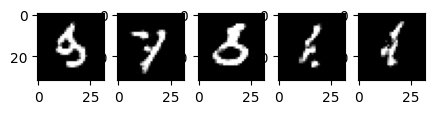

train[10]: 100%|██████████| 469/469 [01:07<00:00,  6.96it/s, loss:0.00600]


epoch[10] : -0.00002


test[10]: 100%|██████████| 469/469 [00:21<00:00, 22.02it/s]


epoch[10] : test loss - 0.00600


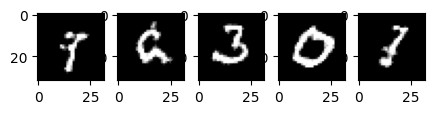

train[11]: 100%|██████████| 469/469 [01:07<00:00,  6.97it/s, loss:0.00493]


epoch[11] : -0.00016


test[11]: 100%|██████████| 469/469 [00:21<00:00, 22.09it/s]


epoch[11] : test loss - 0.00493


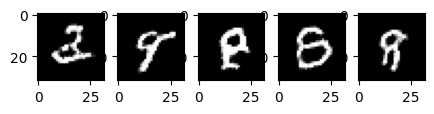

train[12]: 100%|██████████| 469/469 [01:07<00:00,  6.94it/s, loss:0.00510]


epoch[12] : -0.00010


test[12]: 100%|██████████| 469/469 [00:21<00:00, 22.23it/s]


epoch[12] : test loss - 0.00510


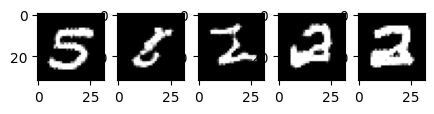

train[13]: 100%|██████████| 469/469 [01:07<00:00,  6.97it/s, loss:0.00471]


epoch[13] : 0.00017


test[13]: 100%|██████████| 469/469 [00:21<00:00, 22.11it/s]


epoch[13] : test loss - 0.00471


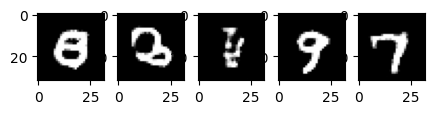

train[14]: 100%|██████████| 469/469 [01:07<00:00,  6.97it/s, loss:0.00537]


epoch[14] : 0.00011


test[14]: 100%|██████████| 469/469 [00:21<00:00, 22.15it/s]


epoch[14] : test loss - 0.00537


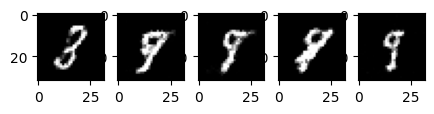

train[15]: 100%|██████████| 469/469 [01:07<00:00,  6.94it/s, loss:0.00974]


epoch[15] : -0.00034


test[15]: 100%|██████████| 469/469 [00:21<00:00, 22.10it/s]


epoch[15] : test loss - 0.00974


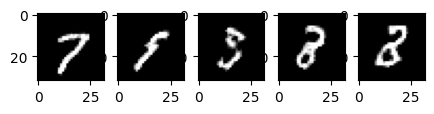

train[16]: 100%|██████████| 469/469 [01:07<00:00,  6.97it/s, loss:0.00710]


epoch[16] : -0.00001


test[16]: 100%|██████████| 469/469 [00:21<00:00, 21.87it/s]


epoch[16] : test loss - 0.00710


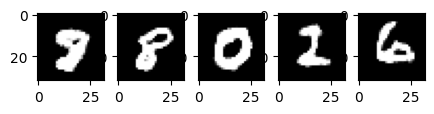

train[17]: 100%|██████████| 469/469 [01:07<00:00,  6.98it/s, loss:0.00503]


epoch[17] : 0.00003


test[17]: 100%|██████████| 469/469 [00:21<00:00, 22.19it/s]


epoch[17] : test loss - 0.00503


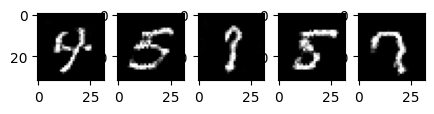

train[18]: 100%|██████████| 469/469 [01:07<00:00,  6.92it/s, loss:0.00524]


epoch[18] : -0.00007


test[18]: 100%|██████████| 469/469 [00:21<00:00, 22.18it/s]


epoch[18] : test loss - 0.00524


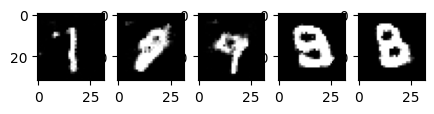

train[19]: 100%|██████████| 469/469 [01:07<00:00,  6.92it/s, loss:0.00598]


epoch[19] : -0.00013


test[19]: 100%|██████████| 469/469 [00:21<00:00, 22.11it/s]


epoch[19] : test loss - 0.00598


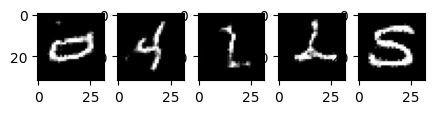

In [41]:
def train(model, buffer, optimizer, n_epoch, train_dl, test_dl, device):

    loss_history = []
    loss_test_history = []
    alpha = 0.1

    for epoch in range(n_epoch):
        model.train()
        loss_sum = 0
        n_total = 0
        pbar = tqdm(train_dl, desc=f"train[{epoch}]")
        for _, (x, _) in enumerate(pbar):
            optimizer.zero_grad()
            # add random noise to data to prevent overfitting
            x += torch.randn_like(x) * 0.005 # 0.005 is stddev
            x = torch.clip(x, -1.0, 1.0)
            x = x.to(device)

            # get samples from buffer
            fake_imgs = buffer.sample_new_exmps(steps=60, step_size=10, noise=0.005)
            inp_imgs = torch.concat([x, fake_imgs], dim = 0)
            real_out, fake_out = torch.vsplit(model(inp_imgs), 2)

            # loss : -(\nabla model(x_train) - \nabla model(x_sample))
            contrastive_divergence_loss = -(
                torch.mean(real_out, dim=0) # x_train
                - torch.mean(fake_out, dim = 0) #x_sample
                )
            reg_loss = alpha * (torch.mean(real_out ** 2 + fake_out ** 2, dim=0))
            loss = contrastive_divergence_loss + reg_loss

            loss_sum += loss.item() * x.shape[0]
            n_total += x.shape[0]

            pbar.set_postfix_str(f"loss:{loss.item():.5f}")
            loss.backward()
            optimizer.step()

        epoch_loss = loss_sum / n_total
        print(f"epoch[{epoch}] : {epoch_loss:.5f}")
        loss_history.append(epoch_loss)

        model.eval()
        pbar = tqdm(train_dl, desc=f"test[{epoch}]")

        loss_sum_test = 0
        n_total_test = 0
        with torch.no_grad():
            for _, (x, _) in enumerate(pbar):
                fake_imgs = (torch.rand([x.shape[0], 1,32,32], device=device) * 2 - 1)
                x = x.to(device)
                inp_imgs = torch.concat([x, fake_imgs], dim = 0)
                real_out, fake_out = torch.vsplit(model(inp_imgs), 2)
                contrastive_divergence_loss = -(
                    torch.mean(real_out, dim=0) # x_train
                    - torch.mean(fake_out, dim = 0) #x_sample
                )

                loss_sum_test += loss.item() * x.shape[0]
                n_total_test += x.shape[0]

        epoch_test_loss = loss_sum_test / n_total_test
        print(f"epoch[{epoch}] : test loss - {epoch_test_loss:.5f}")
        loss_test_history.append(epoch_test_loss)

        # test
        start_imgs = torch.rand([5, 1,32,32], device=device, requires_grad=True) * 2 - 1

        gen_imgs = generate_samples(model=model, inp_imgs=start_imgs, steps=1000, step_size=10, noise=0.005)
        gen_imgs = gen_imgs.squeeze().detach().cpu().numpy()
        fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(5,1))
        for i in range(5):
            axs[i].imshow(gen_imgs[i], cmap='gray')
        plt.show()

    return loss_history

device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 128

model = model.to(device)
buffer = Buffer(model, batch_size, device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
dl = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
loss_history = train(model, buffer, optimizer, 20, dl, test_dl, device)

In [42]:
torch.save(model.state_dict(), "model.pt")